# 找出 MultiTaskLasso 在 simplex 以及 sparse 空間上的目標值上的解，並用這個當作是在該參數空間上的最佳解來生成資料給 MOBO 用

當你 fit 好一個 Multi Task Lasso 的時候，透過這個模型在 simplex 及 sparse 空間上找到最佳解

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler

from scipy.optimize import nnls, minimize

In [2]:
def find_best_x(model, target_y) -> np.ndarray:
    # 1. 提取係數矩陣 W (n_tasks, n_features)
    W = model.coef_ 
    
    # 2. 調整 target_y (處理截距)
    # y = XW^T + b  =>  y - b = XW^T
    y_adj = target_y - model.intercept_
    
    # 3. 求解 X。因為 y_adj 是 (tasks,), W 是 (tasks, features)
    # 我們要解的方程是 X @ W.T = y_adj
    # 這等同於解 W @ X.T = y_adj.T
    
    # 使用最小二乘法求解
    # rcond=None 會自動處理奇異矩陣或非方陣情況
    x_solution, residuals, rank, s = np.linalg.lstsq(W, y_adj, rcond=None)
    
    return x_solution

def find_best_positive_x(model, target_y) -> np.ndarray:
    # 1. 提取權重矩陣 W (n_tasks, n_features)
    # 在我們的方程 y = XW^T 中，W 扮演了傳統線性方程 Ax=b 中 A 的角色
    A = model.coef_.T  # 注意：轉置後形狀為 (n_tasks, n_features)
    
    # 如果 model.coef_ 形狀是 (n_tasks, n_features)
    # 我們要解的是 (n_tasks, n_features) @ (n_features, 1) = (n_tasks, 1)
    # 所以 A 就是 model.coef_
    A = model.coef_
    
    # 2. 扣除截距
    b = target_y - model.intercept_
    
    # 3. 使用 NNLS 求解
    # x_solution 是解，error 是殘差的二範數
    x_solution, error = nnls(A, b)
    
    return x_solution

def old_find_x_with_constraints(model, target_y=None, alpha=0, maximize=False):
    # 1. 準備矩陣 A 與目標 b
    # A 為 W (n_tasks, n_features), b 為 y - intercept
    A = model.coef_
    B = model.intercept_
    # b = target_y - model.intercept_

    n_features = A.shape[1]

    # 2. 定義目標函數：最小化 ||Ax - b||^2
    def objective(x):
        if target_y is not None:
            main_term = np.sum( (np.dot(A, x) + B - target_y)**2 )
        else:
            main_term = np.sum( (np.dot(A, x) + B)**2 )

        if alpha > 0:
            penalty_term = np.sum(np.exp( -1/2 * np.square(x/alpha) ))
        else:
            penalty_term = 0
        
        object_fun =  main_term + penalty_term
        if maximize:
            object_fun = object_fun * -1
        return object_fun
    
    # 3. 定義約束條件：所有 x 的總和等於 100
    # scipy 的 'eq' 代表該式子結果必須為 0
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 100})

    # 4. 定義邊界條件：每個 x 都必須 >= 0
    bounds = [(0, 100) for _ in range(n_features)]

    # 5. 給予一個初始猜測值 (例如平均分配 100)
    x0 = np.ones(n_features) * (100 / n_features)

    # 6. 開始求解 (使用 SLSQP 演算法支援約束與邊界)
    res = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)

    if res.success:
        return res.x
    else:
        raise ValueError("優化失敗：" + res.message)
    
def find_x_with_constraints(model_info, sparse_alpha=0, maximize=False):
    pipe:Pipeline = model_info['model_info']['PIPE']
    n_features = len(model_info['data_cols'])
    print('n_features: {}'.format(n_features))
    # 定義目標函數：
    def objective(x):
        input_data = pd.DataFrame(x).T
        input_data.columns = model_info['data_cols']


        main_term = np.sum(np.square(pipe.predict(input_data) ))       
        penalty_term = np.sum(np.exp( -1/2 * np.square(x/sparse_alpha) )) if sparse_alpha > 0 else 0
        object_value =  main_term + penalty_term
        if maximize:
            object_value = object_value * -1
        return object_value
    
    # 定義約束條件：所有 x 的總和等於 100
    # scipy 的 'eq' 代表該式子結果必須為 0
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 100})

    # 定義邊界條件：每個 x 都必須 >= 0
    bounds = [(0, 100) for _ in range(n_features)]

    # 給予一個初始猜測值 (例如平均分配 100)
    x0 = np.ones(n_features) * (100 / n_features)

    # 開始求解 (使用 SLSQP 演算法支援約束與邊界)
    res = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)
    return res
    # if res.success:
    #     return res.x
    # else:
    #     raise ValueError("優化失敗：" + res.message)


In [3]:
# 讀取 model_info
model_info_path = '/workspaces/BO_EXPERIMENTS/src/results/20260204/PBTc/model/lasso.pkl'
model_info = joblib.load(model_info_path)

# 讀取資料
datapath = '/workspaces/BO_EXPERIMENTS/src/datasets/LIMS_automl_20251201_170130_MV260final_fullMerged_median_clean_10_sum100_no_rare_GF.csv'
data = pd.read_csv(datapath)
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

# 生成資料儲存位置
generate_data_dir = '/workspaces/BO_EXPERIMENTS/src/datasets/mt_lasso_dataset/interactive_term/'
generate_data_path = os.path.join(generate_data_dir, 'data.pkl')
os.makedirs(generate_data_dir, exist_ok=True)


In [4]:
# # 透過廷俞報告的近似 L0 的懲罰項來收斂 sparse simplex 空間中的解
# # model = model_info['pipe']['model']
# res = find_x_with_constraints(model_info, sparse_alpha= 1, maximize=True)
# if res.success:
#     x_star = res.x.round(4)
#     x_star_data = pd.DataFrame(x_star).T
#     x_star_data.columns = model_info['data_cols']
#     y_star = model_info['model_info']['PIPE'].predict(x_star_data)
#     print(x_star)
#     print(y_star)
# else:
#     x_star = res.x.round(4)
#     x_star_data = pd.DataFrame(x_star).T
#     x_star_data.columns = model_info['data_cols']
#     y_star = model_info['model_info']['PIPE'].predict(x_star_data)
#     print(x_star)
#     print(y_star)
#     print('優化失敗，無法找到極值')

In [5]:
coef = model_info['model_info']['PIPE'].regressor_['model'].coef_
non_zero = coef[coef.round(4) != 0]
print(non_zero.shape)
print(coef.shape)

(120,)
(2, 210)


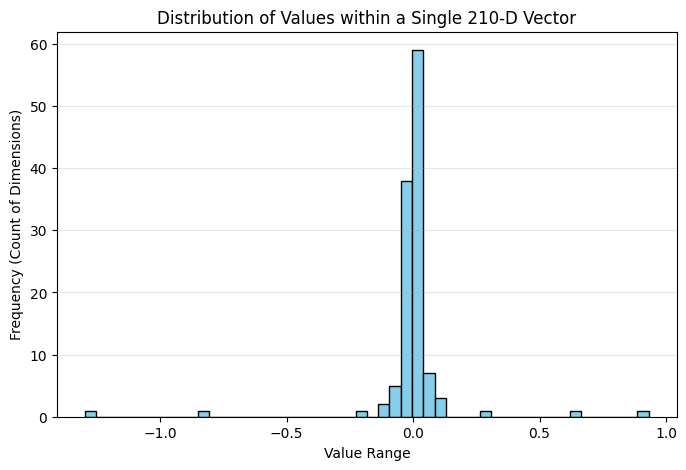

In [6]:
# 繪製模型系數的分布圖
plt.figure(figsize=(8, 5))
plt.hist(non_zero, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Values within a Single {}-D Vector".format(coef.shape[-1]))
plt.xlabel("Value Range")
plt.ylabel("Frequency (Count of Dimensions)")
plt.grid(axis='y', alpha=0.3)
output_plot_path = os.path.join(generate_data_dir, 'coef_distribution.png')
plt.savefig(output_plot_path, bbox_inches='tight')
plt.show()

In [7]:
# 隨機生成 1000 筆 sparse simplex X 資料
N = 1000
D = len(model_info['data_cols'])
k = 5
X_samples = []
for i in range(N):
    x = np.zeros((1, D))

    # 隨機取 k 個 active term
    active_term = np.random.choice(np.arange(D), size=k, replace=False)

    # 從 dirichlet distribution 中生成 1000 筆資料
    alpha = np.ones(k)
    active_mixtures = np.random.dirichlet(alpha, size=1)

    # 將 active_mixtures 加到原本資料中的 active_term 中
    x[:, active_term] = active_mixtures
    X_samples.append(x)

X_samples = np.concat(X_samples, axis=0) * 100

In [8]:
# 透過 X_samples 生成 Y_samples
X_samples = pd.DataFrame(X_samples, columns=model_info['data_cols'])
Y_samples = model_info['model_info']['PIPE'].predict(X_samples)

# # 隨機生成殘差
# mean = [0, 0]
# cov = [[0.01, 0], [0, 0.01]]
# residual = np.random.multivariate_normal(mean, cov, Y_samples.shape[0])
# Y_samples = Y_samples + residual
# Y_samples = pd.DataFrame(Y_samples, columns=model_info['target_cols'])

In [9]:
np.corrcoef(Y_samples, rowvar=False)

array([[ 1.        , -0.91925871],
       [-0.91925871,  1.        ]])

In [10]:
# 儲存資料
save_data = {
    'initial_data': {
        'X': X_samples,
        'Y': Y_samples,
    },
    # 'ground_truth': {
    #     'X': x_star,
    #     'Y': y_star
    # },
    'oracle_model': model_info
}

joblib.dump(save_data, generate_data_path)

['/workspaces/BO_EXPERIMENTS/src/datasets/mt_lasso_dataset/interactive_term/data.pkl']